In [1]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot

import skxray.core.speckle as xsvs
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as utils
import skxray.core.fitting as fitt

import numpy as np
import os, sys

import matplotlib as mpl
import matplotlib.pyplot as plt

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from lmfit import Model
from scipy import stats

### Easily switch between interactive and static matplotlib plots¶

In [4]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

# if matplotlib version 1.5 or later
if float('.'.join(mpl.__version__.split('.')[:2])) >= 1.5:
    cmap = 'viridis'
else:
    cmap = 'CMRmap'


In [5]:
%run download.py

__file__
current_folder = /Volumes/Data/All_NSLS2/scikit-xray-examples/demos/speckle
current_folder = /Volumes/Data/All_NSLS2/scikit-xray-examples/demos/speckle


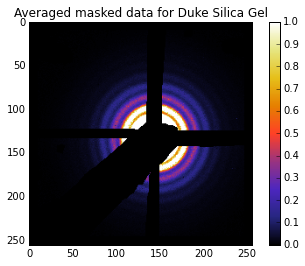

In [6]:
data_dir = "Duke_data/"
duke_rdata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_rdata.shape[0]):
    duke_data.append(duke_rdata[i] - duke_dark)
    
duke_ndata=np.asarray(duke_data)

# load the mask(s) and mask the data
mask1 = np.load(data_dir+"new_mask4.npy")
mask2 = np.load(data_dir+"Luxi_duke_mask.npy")

N_mask = ~(mask1 + mask2)

mask_data = N_mask*duke_ndata

#  get the average image
avg_img = np.average(duke_ndata, axis=0)

# plot the average image data after masking
plt.figure()
plt.imshow(N_mask*avg_img, vmax=1e0, cmap=cmap)
plt.title("Averaged masked data for Duke Silica Gel ")
plt.colorbar()
plt.show()

In [7]:
inner_radius = 26  # radius of the first ring
width = 1        # width of each ring
spacing = 0      # no spacing between rings
num_rings = 4    # number of rings
center = (133, 143)   # center of the spckle pattern

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

# convert to q ( reciprocal values)
dpix = 0.055  # The physical size of the pixels

lambda_ = 1.5498  # wavelength of the X-rays
Ldet = 2200.   #   # detector to sample distance

two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_val = utils.twotheta_to_q(two_theta, lambda_)
q_ring = np.mean(q_val, axis=1)
q_ring

array([ 0.0026859 ,  0.00278726,  0.00288861,  0.00298997])

In [8]:
rings = roi.rings(edges, center, avg_img.shape)

images_sets = (mask_data, )

ring_mask = rings*N_mask

max_cts = roi.roi_max_counts(images_sets, ring_mask)
max_cts

24

In [9]:
spe_cts_all, std_dev = xsvs.xsvs(images_sets, ring_mask, timebin_num=2,
                             number_of_img=20, max_cts=max_cts)

In [10]:
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)
mean_int_ring = np.mean(mean_int_sets, axis=0)
mean_int_ring

array([ 3.17503051,  2.03199322,  1.22062687,  0.78536136])

In [11]:
time_steps = utils.geometric_series(2, 30)
time_steps
num_times = 6
num_rois=num_rings
norm_bin_edges, norm_bin_centers = xsvs.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

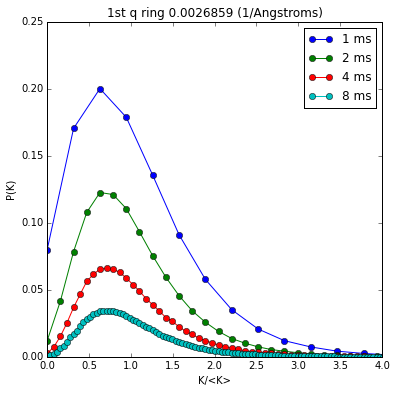

In [12]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], spe_cts_all[i, 0], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("1st q ring 0.0026859 (1/Angstroms)")
plt.show()

In [13]:
M = 1.013

gamma_model = Model(fitt.gamma_dist)
nbinom_model = Model(fitt.nbinom_dist)
po_model = Model(fitt.poisson_dist)

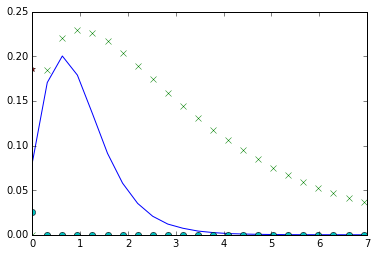

In [15]:
M= 1.4578
out_g00 = gamma_model.eval(bin_edges=norm_bin_edges[0, 0][:-1],
                           K = mean_int_ring[0], M=M)
re_g00 = gamma_model.fit(out_g00, bin_edges=norm_bin_edges[0, 0][:-1],
                         K = mean_int_ring[0], M=M)

out_n00 = nbinom_model.eval(bin_edges=norm_bin_edges[0, 0][:-1],
                            K = mean_int_ring[0], M=M)
re_n00 = nbinom_model.fit(out_n00, bin_edges=norm_bin_edges[0, 0][:-1],
                          K = mean_int_ring[0], M=M)

out_p00 = po_model.eval(bin_edges=norm_bin_edges[0, 0][:-1], K =3.67)
re_p00 = po_model.fit(out_p00, bin_edges=norm_bin_edges[0, 0][:-1], K=3.67)

plt.figure()
plt.plot(norm_bin_edges[0, 0][:-1], spe_cts_all[0, 0], '-')
plt.plot(norm_bin_edges[0, 0][:-1], re_g00.best_fit, 'x')
plt.plot(norm_bin_edges[0,0][:-1], re_n00.best_fit, '*')
plt.plot(norm_bin_edges[0, 0][:-1], re_p00.best_fit, 'o')
plt.show()